# Caltech-101 分类任务
- 数据集划分（7:1.5:1.5，train/val/test）
- 数据加载与增强
- 微调ResNet-18模型
- TensorBoard日志记录
- 测试与结果对比和保存

In [ ]:
import os, shutil, random
from pathlib import Path
from tqdm import tqdm

def split_caltech101(original_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, min_images=10, seed=42):
    random.seed(seed)

    original_dir = Path(original_dir)
    output_dir = Path(output_dir)

    # 创建三个目标子目录
    for phase in ['train', 'val', 'test']:
        (output_dir / phase).mkdir(parents=True, exist_ok=True)

    for class_folder in tqdm(sorted(os.listdir(original_dir))):
        class_path = original_dir / class_folder
        if not class_path.is_dir():
            continue
        if class_folder.lower().startswith('background') or class_folder.lower().startswith('annotation'):
            continue

        # 收集图像
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if len(images) < min_images:
            continue

        random.shuffle(images)

        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)
        n_test = n_total - n_train - n_val  

        split_data = {
            'train': images[:n_train],
            'val': images[n_train:n_train + n_val],
            'test': images[n_train + n_val:]
        }

        for phase, img_list in split_data.items():
            target_class_dir = output_dir / phase / class_folder
            target_class_dir.mkdir(parents=True, exist_ok=True)
            for img in img_list:
                shutil.copy(class_path / img, target_class_dir / img)

split_caltech101(
    original_dir='/kaggle/input/caltech-101/caltech-101',
    output_dir='/kaggle/input/caltech-101/caltech101_split_3way',
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    min_images=10,
    seed=42
)


In [9]:
best_params = {
    'lr_fc': 1e-3,
    'lr_backbone': 1e-5,
    'num_epochs': 25,
    'l2': 1e-5,
    'batch_size': 64,
    'optimizer': 'AdamW',  
}


In [10]:
# 用搜索得到的 batch_size 重新设置 dataloaders
batch_size = best_params['batch_size']

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([  # 新增test数据的transform
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# 加载训练集、验证集和测试集
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x == 'train'), num_workers=4) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)


In [11]:
import pickle

def train_model(model, dataloaders, dataset_sizes, device,
                num_epochs, lr_fc, lr_backbone, weight_decay,
                log_name='run', fine_tune=True, optimizer_type='SGD'):

    writer = SummaryWriter(log_dir=f'runs/{log_name}')
    criterion = nn.CrossEntropyLoss()

    if fine_tune:
        params = [
            {'params': model.fc.parameters(), 'lr': lr_fc},
            {'params': [p for n, p in model.named_parameters() if 'fc' not in n], 'lr': lr_backbone}
        ]
    else:
        params = model.parameters()

    if optimizer_type == 'SGD':
        optimizer = optim.SGD(params, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_type == 'AdamW':
        optimizer = optim.AdamW(params, weight_decay=weight_decay)
    else:
        raise ValueError(f'Unsupported optimizer: {optimizer_type}')

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0

            loop = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} [{epoch+1}/{num_epochs}]')
            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            writer.add_scalar(f'{phase}_loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase}_acc', epoch_acc, epoch)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # 保存最佳模型权重为 .pkl 文件
        with open('best_model.pkl', 'wb') as f:
            pickle.dump(best_model_wts, f)
        print(f"Best model saved as 'best_model.pkl' with accuracy: {best_acc:.4f}")

    print(f'\nBest val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model


In [12]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader, class_names, device, title='Confusion Matrix'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f'\n Test Accuracy: {acc:.4f}')

    # Classification Report
    print("\nMore Classification Details:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Epoch 1/25


Train [1/25]: 100%|██████████| 95/95 [00:14<00:00,  6.75it/s]


train Loss: 3.7323 Acc: 0.2303


Val [1/25]: 100%|██████████| 20/20 [00:02<00:00,  6.68it/s]


val Loss: 3.7754 Acc: 0.2731
Best model saved as 'best_model.pkl' with accuracy: 0.2731

Epoch 2/25


Train [2/25]: 100%|██████████| 95/95 [00:12<00:00,  7.48it/s]


train Loss: 3.3002 Acc: 0.2773


Val [2/25]: 100%|██████████| 20/20 [00:02<00:00,  7.45it/s]


val Loss: 3.3679 Acc: 0.2906
Best model saved as 'best_model.pkl' with accuracy: 0.2906

Epoch 3/25


Train [3/25]: 100%|██████████| 95/95 [00:12<00:00,  7.50it/s]


train Loss: 3.0982 Acc: 0.3052


Val [3/25]: 100%|██████████| 20/20 [00:02<00:00,  7.61it/s]


val Loss: 3.2967 Acc: 0.2659
Best model saved as 'best_model.pkl' with accuracy: 0.2906

Epoch 4/25


Train [4/25]: 100%|██████████| 95/95 [00:12<00:00,  7.42it/s]


train Loss: 2.9484 Acc: 0.3279


Val [4/25]: 100%|██████████| 20/20 [00:02<00:00,  7.02it/s]


val Loss: 2.7505 Acc: 0.3439
Best model saved as 'best_model.pkl' with accuracy: 0.3439

Epoch 5/25


Train [5/25]: 100%|██████████| 95/95 [00:12<00:00,  7.48it/s]


train Loss: 2.7408 Acc: 0.3697


Val [5/25]: 100%|██████████| 20/20 [00:02<00:00,  7.59it/s]


val Loss: 2.8533 Acc: 0.3599
Best model saved as 'best_model.pkl' with accuracy: 0.3599

Epoch 6/25


Train [6/25]: 100%|██████████| 95/95 [00:12<00:00,  7.50it/s]


train Loss: 2.6188 Acc: 0.3852


Val [6/25]: 100%|██████████| 20/20 [00:02<00:00,  6.73it/s]


val Loss: 2.5453 Acc: 0.3965
Best model saved as 'best_model.pkl' with accuracy: 0.3965

Epoch 7/25


Train [7/25]: 100%|██████████| 95/95 [00:12<00:00,  7.48it/s]


train Loss: 2.5205 Acc: 0.4008


Val [7/25]: 100%|██████████| 20/20 [00:02<00:00,  7.74it/s]


val Loss: 2.5490 Acc: 0.3925
Best model saved as 'best_model.pkl' with accuracy: 0.3965

Epoch 8/25


Train [8/25]: 100%|██████████| 95/95 [00:12<00:00,  7.45it/s]


train Loss: 2.3999 Acc: 0.4222


Val [8/25]: 100%|██████████| 20/20 [00:02<00:00,  7.42it/s]


val Loss: 2.5758 Acc: 0.4005
Best model saved as 'best_model.pkl' with accuracy: 0.4005

Epoch 9/25


Train [9/25]: 100%|██████████| 95/95 [00:12<00:00,  7.45it/s]


train Loss: 2.2560 Acc: 0.4466


Val [9/25]: 100%|██████████| 20/20 [00:02<00:00,  7.66it/s]


val Loss: 2.4207 Acc: 0.4363
Best model saved as 'best_model.pkl' with accuracy: 0.4363

Epoch 10/25


Train [10/25]: 100%|██████████| 95/95 [00:12<00:00,  7.50it/s]


train Loss: 2.1898 Acc: 0.4615


Val [10/25]: 100%|██████████| 20/20 [00:02<00:00,  7.58it/s]


val Loss: 2.1846 Acc: 0.4554
Best model saved as 'best_model.pkl' with accuracy: 0.4554

Epoch 11/25


Train [11/25]: 100%|██████████| 95/95 [00:12<00:00,  7.38it/s]


train Loss: 2.1059 Acc: 0.4789


Val [11/25]: 100%|██████████| 20/20 [00:02<00:00,  7.64it/s]


val Loss: 2.0469 Acc: 0.5048
Best model saved as 'best_model.pkl' with accuracy: 0.5048

Epoch 12/25


Train [12/25]: 100%|██████████| 95/95 [00:12<00:00,  7.50it/s]


train Loss: 1.9800 Acc: 0.5080


Val [12/25]: 100%|██████████| 20/20 [00:02<00:00,  7.67it/s]


val Loss: 1.9842 Acc: 0.4801
Best model saved as 'best_model.pkl' with accuracy: 0.5048

Epoch 13/25


Train [13/25]: 100%|██████████| 95/95 [00:12<00:00,  7.32it/s]


train Loss: 1.9119 Acc: 0.5224


Val [13/25]: 100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


val Loss: 1.8943 Acc: 0.5311
Best model saved as 'best_model.pkl' with accuracy: 0.5311

Epoch 14/25


Train [14/25]: 100%|██████████| 95/95 [00:12<00:00,  7.48it/s]


train Loss: 1.8336 Acc: 0.5383


Val [14/25]: 100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


val Loss: 1.8941 Acc: 0.5318
Best model saved as 'best_model.pkl' with accuracy: 0.5318

Epoch 15/25


Train [15/25]: 100%|██████████| 95/95 [00:12<00:00,  7.40it/s]


train Loss: 1.7364 Acc: 0.5599


Val [15/25]: 100%|██████████| 20/20 [00:02<00:00,  7.92it/s]


val Loss: 1.8683 Acc: 0.5287
Best model saved as 'best_model.pkl' with accuracy: 0.5318

Epoch 16/25


Train [16/25]: 100%|██████████| 95/95 [00:12<00:00,  7.47it/s]


train Loss: 1.7000 Acc: 0.5581


Val [16/25]: 100%|██████████| 20/20 [00:02<00:00,  8.02it/s]


val Loss: 1.9759 Acc: 0.5263
Best model saved as 'best_model.pkl' with accuracy: 0.5318

Epoch 17/25


Train [17/25]: 100%|██████████| 95/95 [00:12<00:00,  7.40it/s]


train Loss: 1.6448 Acc: 0.5753


Val [17/25]: 100%|██████████| 20/20 [00:02<00:00,  7.70it/s]


val Loss: 1.5770 Acc: 0.6178
Best model saved as 'best_model.pkl' with accuracy: 0.6178

Epoch 18/25


Train [18/25]: 100%|██████████| 95/95 [00:12<00:00,  7.50it/s]


train Loss: 1.5706 Acc: 0.5826


Val [18/25]: 100%|██████████| 20/20 [00:02<00:00,  7.65it/s]


val Loss: 1.7532 Acc: 0.5589
Best model saved as 'best_model.pkl' with accuracy: 0.6178

Epoch 19/25


Train [19/25]: 100%|██████████| 95/95 [00:12<00:00,  7.41it/s]


train Loss: 1.4829 Acc: 0.6067


Val [19/25]: 100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


val Loss: 1.4791 Acc: 0.6154
Best model saved as 'best_model.pkl' with accuracy: 0.6178

Epoch 20/25


Train [20/25]: 100%|██████████| 95/95 [00:12<00:00,  7.51it/s]


train Loss: 1.4504 Acc: 0.6130


Val [20/25]: 100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


val Loss: 1.4544 Acc: 0.6457
Best model saved as 'best_model.pkl' with accuracy: 0.6457

Epoch 21/25


Train [21/25]: 100%|██████████| 95/95 [00:12<00:00,  7.45it/s]


train Loss: 1.3965 Acc: 0.6338


Val [21/25]: 100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


val Loss: 1.3739 Acc: 0.6369
Best model saved as 'best_model.pkl' with accuracy: 0.6457

Epoch 22/25


Train [22/25]: 100%|██████████| 95/95 [00:12<00:00,  7.51it/s]


train Loss: 1.3017 Acc: 0.6503


Val [22/25]: 100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


val Loss: 1.3411 Acc: 0.6656
Best model saved as 'best_model.pkl' with accuracy: 0.6656

Epoch 23/25


Train [23/25]: 100%|██████████| 95/95 [00:12<00:00,  7.43it/s]


train Loss: 1.3025 Acc: 0.6507


Val [23/25]: 100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


val Loss: 1.4280 Acc: 0.6441
Best model saved as 'best_model.pkl' with accuracy: 0.6656

Epoch 24/25


Train [24/25]: 100%|██████████| 95/95 [00:12<00:00,  7.48it/s]


train Loss: 1.2307 Acc: 0.6668


Val [24/25]: 100%|██████████| 20/20 [00:02<00:00,  7.55it/s]


val Loss: 1.3800 Acc: 0.6568
Best model saved as 'best_model.pkl' with accuracy: 0.6656

Epoch 25/25


Train [25/25]: 100%|██████████| 95/95 [00:12<00:00,  7.50it/s]


train Loss: 1.2698 Acc: 0.6593


Val [25/25]: 100%|██████████| 20/20 [00:02<00:00,  7.90it/s]


val Loss: 1.3179 Acc: 0.6624
Best model saved as 'best_model.pkl' with accuracy: 0.6656

Best val Acc: 0.6656


Evaluating: 100%|██████████| 22/22 [00:03<00:00,  6.38it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Test Accuracy: 0.6502

More Classification Details:
                 precision    recall  f1-score   support

          Faces       0.87      0.82      0.84        66
     Faces_easy       0.83      0.88      0.85        66
       Leopards       0.75      1.00      0.86        30
     Motorbikes       0.86      0.99      0.92       121
      accordion       0.86      0.67      0.75         9
      airplanes       0.77      0.99      0.87       120
         anchor       1.00      0.14      0.25         7
            ant       0.00      0.00      0.00         7
         barrel       0.50      0.12      0.20         8
           bass       0.50      0.22      0.31         9
         beaver       1.00      0.12      0.22         8
      binocular       1.00      0.17      0.29         6
         bonsai       0.65      0.85      0.74        20
          brain       0.58      0.69      0.63        16
   brontosaurus       0.50      0.71      0.59         7
         buddha       0.77      0

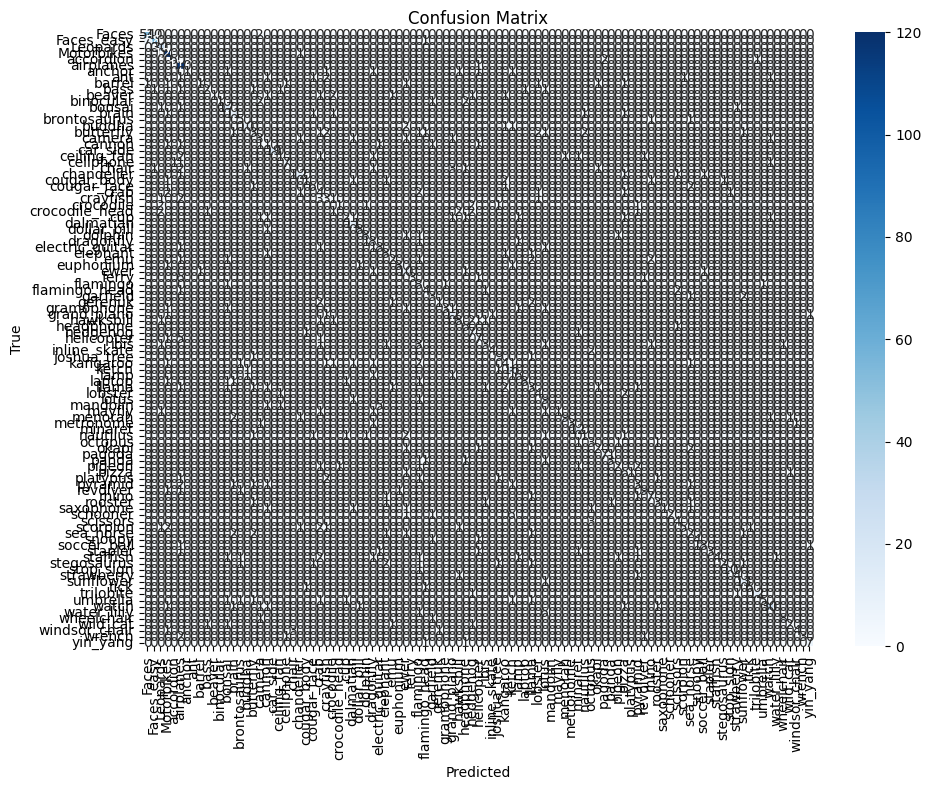

In [13]:
model_scratch = models.resnet18(pretrained=False)
model_scratch.fc = nn.Linear(model_scratch.fc.in_features, num_classes)
model_scratch = model_scratch.to(device)

model_scratch = train_model(model_scratch, dataloaders, dataset_sizes, device,
                            num_epochs=best_params['num_epochs'],
                            lr_fc=best_params['lr_fc'],
                            lr_backbone=best_params['lr_fc'],  #none
                            weight_decay=best_params['l2'],
                            log_name='scratch_final',
                            fine_tune=False,
                            optimizer_type=best_params['optimizer'])
evaluate_model(model_scratch, dataloaders['test'], class_names, device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/25


Train [1/25]: 100%|██████████| 95/95 [00:12<00:00,  7.38it/s]


train Loss: 2.5784 Acc: 0.4673


Val [1/25]: 100%|██████████| 20/20 [00:02<00:00,  7.78it/s]


val Loss: 1.1167 Acc: 0.7532
Best model saved as 'best_model.pkl' with accuracy: 0.7532

Epoch 2/25


Train [2/25]: 100%|██████████| 95/95 [00:12<00:00,  7.51it/s]


train Loss: 1.0842 Acc: 0.7639


Val [2/25]: 100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


val Loss: 0.5656 Acc: 0.8503
Best model saved as 'best_model.pkl' with accuracy: 0.8503

Epoch 3/25


Train [3/25]: 100%|██████████| 95/95 [00:12<00:00,  7.45it/s]


train Loss: 0.7218 Acc: 0.8316


Val [3/25]: 100%|██████████| 20/20 [00:02<00:00,  7.63it/s]


val Loss: 0.4259 Acc: 0.8750
Best model saved as 'best_model.pkl' with accuracy: 0.8750

Epoch 4/25


Train [4/25]: 100%|██████████| 95/95 [00:12<00:00,  7.41it/s]


train Loss: 0.5857 Acc: 0.8548


Val [4/25]: 100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


val Loss: 0.3635 Acc: 0.8949
Best model saved as 'best_model.pkl' with accuracy: 0.8949

Epoch 5/25


Train [5/25]: 100%|██████████| 95/95 [00:12<00:00,  7.45it/s]


train Loss: 0.4973 Acc: 0.8726


Val [5/25]: 100%|██████████| 20/20 [00:03<00:00,  6.48it/s]


val Loss: 0.3098 Acc: 0.9180
Best model saved as 'best_model.pkl' with accuracy: 0.9180

Epoch 6/25


Train [6/25]: 100%|██████████| 95/95 [00:12<00:00,  7.50it/s]


train Loss: 0.4511 Acc: 0.8848


Val [6/25]: 100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


val Loss: 0.2997 Acc: 0.9108
Best model saved as 'best_model.pkl' with accuracy: 0.9180

Epoch 7/25


Train [7/25]: 100%|██████████| 95/95 [00:12<00:00,  7.49it/s]


train Loss: 0.4073 Acc: 0.8901


Val [7/25]: 100%|██████████| 20/20 [00:02<00:00,  6.93it/s]


val Loss: 0.2746 Acc: 0.9188
Best model saved as 'best_model.pkl' with accuracy: 0.9188

Epoch 8/25


Train [8/25]: 100%|██████████| 95/95 [00:12<00:00,  7.47it/s]


train Loss: 0.3790 Acc: 0.9014


Val [8/25]: 100%|██████████| 20/20 [00:02<00:00,  7.93it/s]


val Loss: 0.2471 Acc: 0.9379
Best model saved as 'best_model.pkl' with accuracy: 0.9379

Epoch 9/25


Train [9/25]: 100%|██████████| 95/95 [00:12<00:00,  7.44it/s]


train Loss: 0.3755 Acc: 0.8979


Val [9/25]: 100%|██████████| 20/20 [00:02<00:00,  7.50it/s]


val Loss: 0.2557 Acc: 0.9291
Best model saved as 'best_model.pkl' with accuracy: 0.9379

Epoch 10/25


Train [10/25]: 100%|██████████| 95/95 [00:12<00:00,  7.39it/s]


train Loss: 0.3355 Acc: 0.9107


Val [10/25]: 100%|██████████| 20/20 [00:02<00:00,  7.97it/s]


val Loss: 0.2471 Acc: 0.9323
Best model saved as 'best_model.pkl' with accuracy: 0.9379

Epoch 11/25


Train [11/25]: 100%|██████████| 95/95 [00:12<00:00,  7.48it/s]


train Loss: 0.3168 Acc: 0.9124


Val [11/25]: 100%|██████████| 20/20 [00:02<00:00,  7.75it/s]


val Loss: 0.2446 Acc: 0.9291
Best model saved as 'best_model.pkl' with accuracy: 0.9379

Epoch 12/25


Train [12/25]: 100%|██████████| 95/95 [00:12<00:00,  7.31it/s]


train Loss: 0.3225 Acc: 0.9124


Val [12/25]: 100%|██████████| 20/20 [00:02<00:00,  7.95it/s]


val Loss: 0.2219 Acc: 0.9419
Best model saved as 'best_model.pkl' with accuracy: 0.9419

Epoch 13/25


Train [13/25]: 100%|██████████| 95/95 [00:12<00:00,  7.49it/s]


train Loss: 0.2826 Acc: 0.9202


Val [13/25]: 100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


val Loss: 0.2248 Acc: 0.9387
Best model saved as 'best_model.pkl' with accuracy: 0.9419

Epoch 14/25


Train [14/25]: 100%|██████████| 95/95 [00:12<00:00,  7.38it/s]


train Loss: 0.2891 Acc: 0.9223


Val [14/25]: 100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


val Loss: 0.2393 Acc: 0.9268
Best model saved as 'best_model.pkl' with accuracy: 0.9419

Epoch 15/25


Train [15/25]: 100%|██████████| 95/95 [00:12<00:00,  7.48it/s]


train Loss: 0.2833 Acc: 0.9180


Val [15/25]: 100%|██████████| 20/20 [00:02<00:00,  7.74it/s]


val Loss: 0.2345 Acc: 0.9244
Best model saved as 'best_model.pkl' with accuracy: 0.9419

Epoch 16/25


Train [16/25]: 100%|██████████| 95/95 [00:12<00:00,  7.39it/s]


train Loss: 0.2644 Acc: 0.9265


Val [16/25]: 100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


val Loss: 0.2399 Acc: 0.9283
Best model saved as 'best_model.pkl' with accuracy: 0.9419

Epoch 17/25


Train [17/25]: 100%|██████████| 95/95 [00:12<00:00,  7.47it/s]


train Loss: 0.2702 Acc: 0.9182


Val [17/25]: 100%|██████████| 20/20 [00:02<00:00,  7.81it/s]


val Loss: 0.2243 Acc: 0.9331
Best model saved as 'best_model.pkl' with accuracy: 0.9419

Epoch 18/25


Train [18/25]: 100%|██████████| 95/95 [00:12<00:00,  7.42it/s]


train Loss: 0.2463 Acc: 0.9268


Val [18/25]: 100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


val Loss: 0.2335 Acc: 0.9339
Best model saved as 'best_model.pkl' with accuracy: 0.9419

Epoch 19/25


Train [19/25]: 100%|██████████| 95/95 [00:12<00:00,  7.50it/s]


train Loss: 0.2329 Acc: 0.9336


Val [19/25]: 100%|██████████| 20/20 [00:02<00:00,  7.75it/s]


val Loss: 0.2311 Acc: 0.9323
Best model saved as 'best_model.pkl' with accuracy: 0.9419

Epoch 20/25


Train [20/25]: 100%|██████████| 95/95 [00:12<00:00,  7.37it/s]


train Loss: 0.2354 Acc: 0.9346


Val [20/25]: 100%|██████████| 20/20 [00:02<00:00,  8.02it/s]


val Loss: 0.2318 Acc: 0.9275
Best model saved as 'best_model.pkl' with accuracy: 0.9419

Epoch 21/25


Train [21/25]: 100%|██████████| 95/95 [00:12<00:00,  7.48it/s]


train Loss: 0.2279 Acc: 0.9354


Val [21/25]: 100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


val Loss: 0.2313 Acc: 0.9283
Best model saved as 'best_model.pkl' with accuracy: 0.9419

Epoch 22/25


Train [22/25]: 100%|██████████| 95/95 [00:12<00:00,  7.42it/s]


train Loss: 0.2301 Acc: 0.9346


Val [22/25]: 100%|██████████| 20/20 [00:02<00:00,  7.97it/s]


val Loss: 0.2272 Acc: 0.9371
Best model saved as 'best_model.pkl' with accuracy: 0.9419

Epoch 23/25


Train [23/25]: 100%|██████████| 95/95 [00:12<00:00,  7.51it/s]


train Loss: 0.2352 Acc: 0.9315


Val [23/25]: 100%|██████████| 20/20 [00:02<00:00,  7.97it/s]


val Loss: 0.2265 Acc: 0.9275
Best model saved as 'best_model.pkl' with accuracy: 0.9419

Epoch 24/25


Train [24/25]: 100%|██████████| 95/95 [00:12<00:00,  7.48it/s]


train Loss: 0.2191 Acc: 0.9376


Val [24/25]: 100%|██████████| 20/20 [00:02<00:00,  8.14it/s]


val Loss: 0.2293 Acc: 0.9355
Best model saved as 'best_model.pkl' with accuracy: 0.9419

Epoch 25/25


Train [25/25]: 100%|██████████| 95/95 [00:12<00:00,  7.49it/s]


train Loss: 0.1960 Acc: 0.9441


Val [25/25]: 100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


val Loss: 0.2476 Acc: 0.9252
Best model saved as 'best_model.pkl' with accuracy: 0.9419

Best val Acc: 0.9419


Evaluating: 100%|██████████| 22/22 [00:02<00:00,  7.73it/s]



 Test Accuracy: 0.9297

More Classification Details:
                 precision    recall  f1-score   support

          Faces       0.95      0.88      0.91        66
     Faces_easy       0.89      0.95      0.92        66
       Leopards       1.00      1.00      1.00        30
     Motorbikes       1.00      1.00      1.00       121
      accordion       1.00      1.00      1.00         9
      airplanes       0.98      1.00      0.99       120
         anchor       1.00      0.71      0.83         7
            ant       0.86      0.86      0.86         7
         barrel       1.00      1.00      1.00         8
           bass       1.00      0.67      0.80         9
         beaver       0.89      1.00      0.94         8
      binocular       0.80      0.67      0.73         6
         bonsai       0.95      0.95      0.95        20
          brain       0.94      0.94      0.94        16
   brontosaurus       0.86      0.86      0.86         7
         buddha       1.00      1

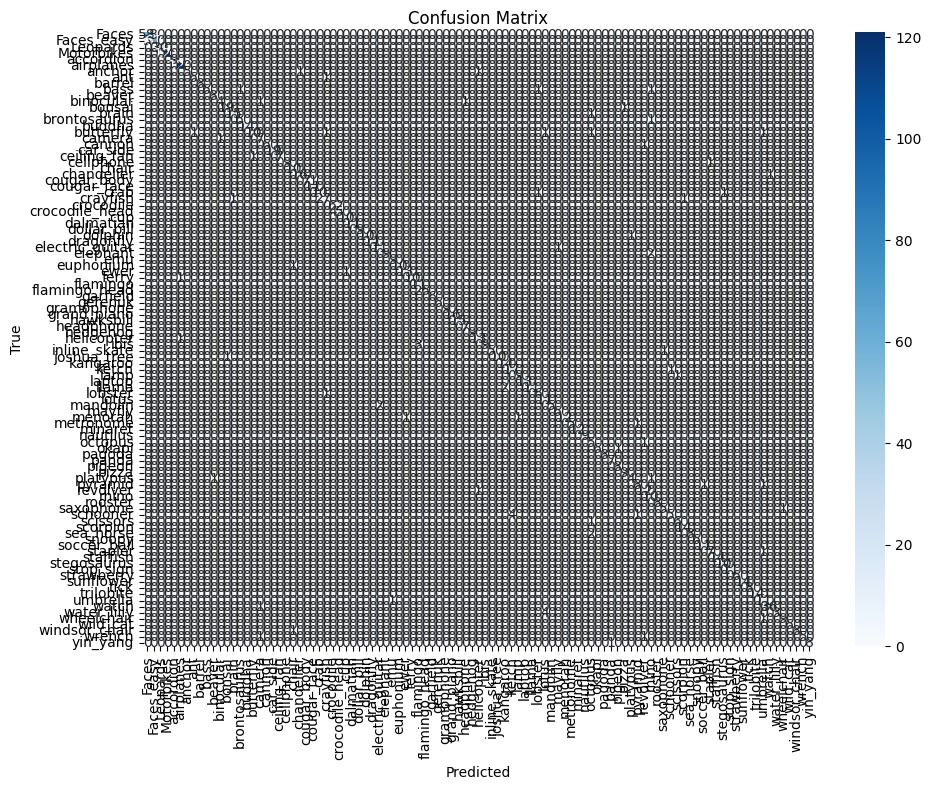

In [14]:
model_finetune = models.resnet18(pretrained=True)
model_finetune.fc = nn.Linear(model_finetune.fc.in_features, num_classes)
model_finetune = model_finetune.to(device)

model_finetune = train_model(model_finetune, dataloaders, dataset_sizes, device,
                             num_epochs=best_params['num_epochs'],
                             lr_fc=best_params['lr_fc'],
                             lr_backbone=best_params['lr_backbone'],
                             weight_decay=best_params['l2'],
                             log_name='finetune_final',
                             fine_tune=True,
                             optimizer_type=best_params['optimizer'])
evaluate_model(model_finetune, dataloaders['test'], class_names, device)